# Section I

**LogisticRegression with changing the default threshold (0.5)for classification**

Using in-build dataset from sklearn itself

## A) Dataset + Model + Evaluation + Threshold

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, StandardScaler

from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis , LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
      accuracy_score, precision_score, confusion_matrix, log_loss 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_features=20, n_samples=1000, random_state=10
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)

# 0.50 (default) --> 0.25
THRESHOLD = 0.25  
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.981818
recall,0.987805
precision,0.975904
roc_auc_score,0.981854


In [ ]:
cm = confusion_matrix(y_test, preds)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[162   4]
 [  2 162]]

True Positives(TP) =  162

True Negatives(TN) =  162

False Positives(FP) =  4

False Negatives(FN) =  2


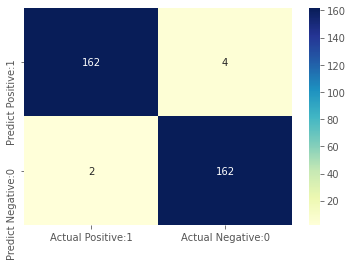

In [ ]:
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

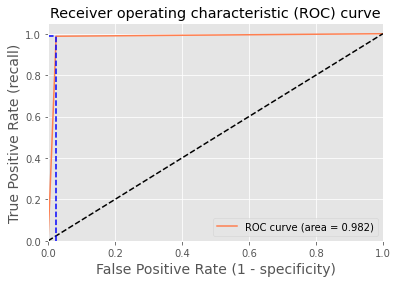

Using a threshold of 1.000 guarantees a sensitivity of 0.988 and a specificity of 0.976, i.e. a false positive rate of 2.41%.


In [ ]:
# check classification scores of logistic regression

[fpr, tpr, thr] = roc_curve(y_test, preds)
idx = np.min(np.where(tpr > 0.80)) # index of the first threshold for which the sensibility > 0.80

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

# Section II

## A) Import library and data

In [ ]:
data = pd.read_csv('dataset_37B/data.csv')
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


There are two diagnosis results and they are in object form.

So if the diagnosis is 1, which means it is cancerous.

    M, malignant: 1, Cancerous
    B, benign: 0, Not Cancerous

## B) Data explorations

In [ ]:
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [ ]:
print('Dimenssion of data (original) :', data.shape)

# remove the irreleavent features
data.drop(['id', 'Unnamed: 32'], inplace=True ,axis=1)

# define dependent variable
data.rename(columns= {"diagnosis":"target"}, inplace=True)

# convert category to numeric
lb = LabelBinarizer()
data['target'] = lb.fit_transform(data['target'].values)

print('Dimenssion of data (processed) :', data.shape)

Dimenssion of data (original) : (569, 33)
Dimenssion of data (processed) : (569, 31)


0    357
1    212
Name: target, dtype: int64


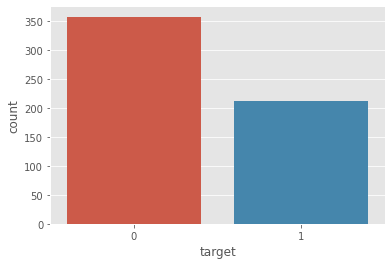

In [ ]:
# target variable - class distribution [diagnosis: B = 0, M = 1]
print(data['target'].value_counts())
sns.countplot(data["target"])
plt.show()

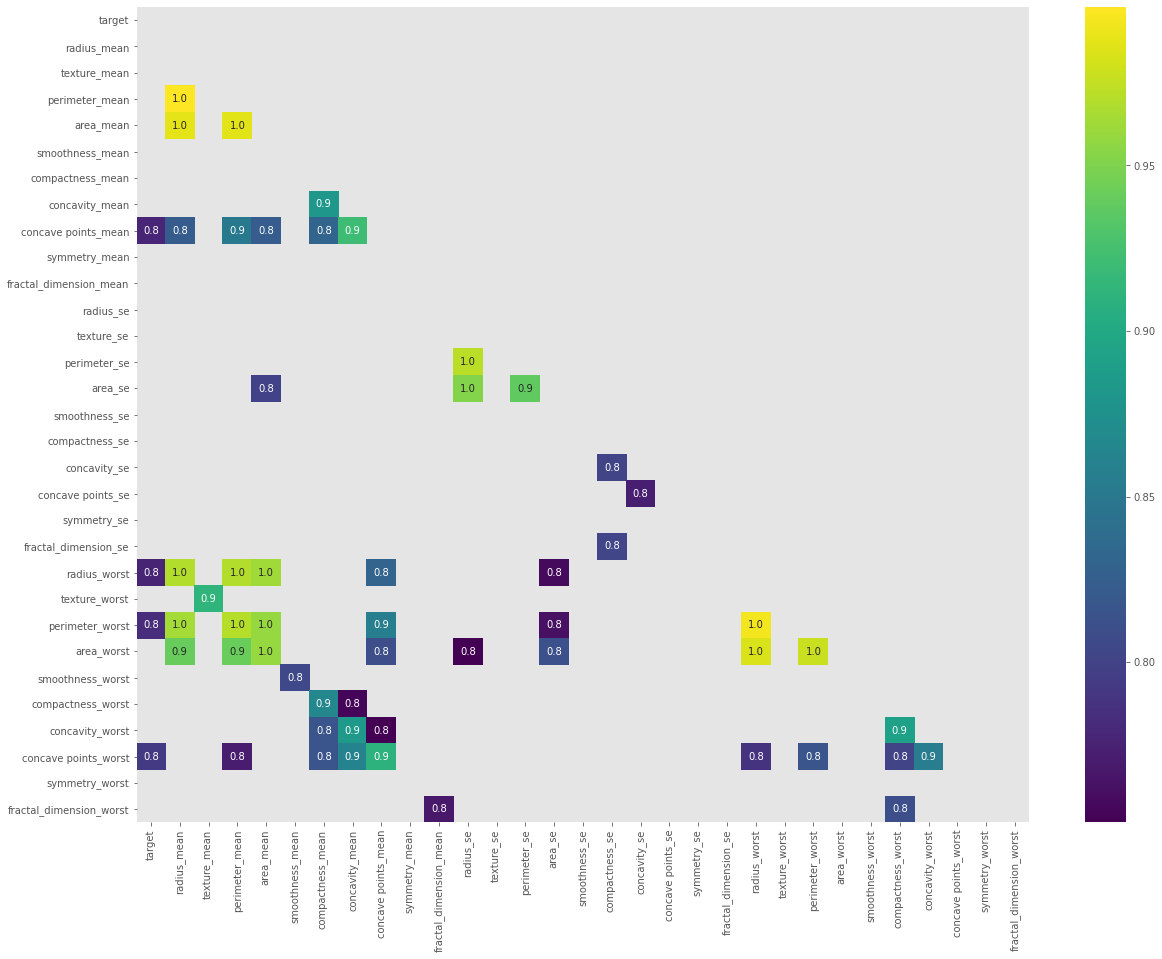

In [ ]:
corr = data.corr()
corr_mat = corr[((corr > 0.75) | (corr < -0.75))]
plt.figure(figsize=(20,15))
sns.heatmap(corr_mat,mask=np.triu(corr_mat),annot=True,fmt='.1f',cmap='viridis')

<Figure size 1440x720 with 0 Axes>

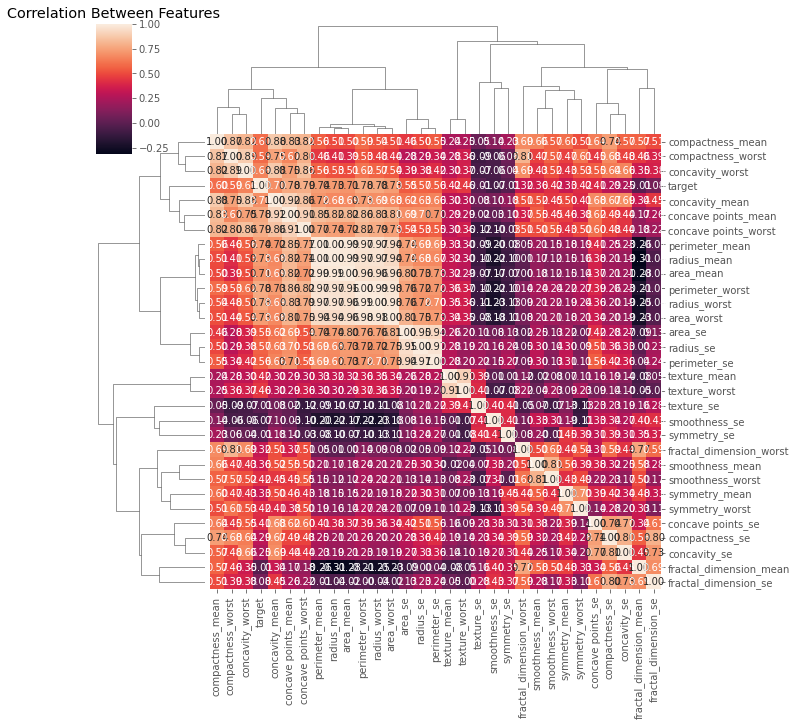

In [ ]:
corr_matrix= data.corr()
plt.figure(figsize=(20,10))
sns.clustermap(corr_matrix, annot=True , fmt=".2f")
plt.title("Correlation Between Features")
plt.show()

<Figure size 720x576 with 0 Axes>

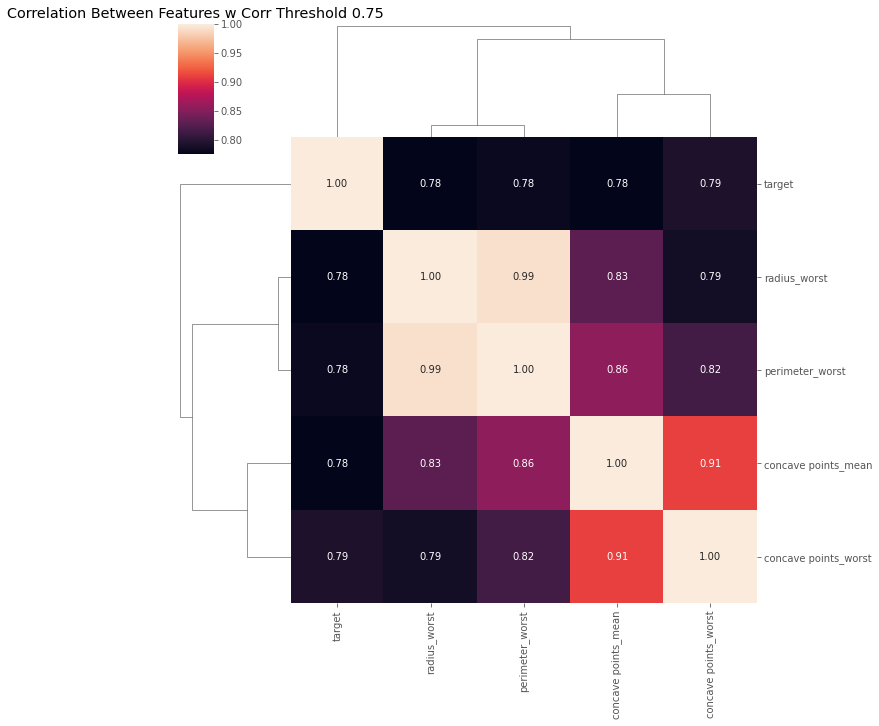

In [ ]:
threshold_corr=0.75
filtre=np.abs(corr_matrix["target"]> threshold_corr)
corr_features=corr_matrix.columns[filtre].tolist()
plt.figure(figsize=(10,8))
sns.clustermap(data[corr_features].corr(), annot=True, fmt=".2f")
plt.title("Correlation Between Features w Corr Threshold 0.75")
plt.show()

Text(0.5, 1.0, 'Overall Correlation of features with Diagnosis')

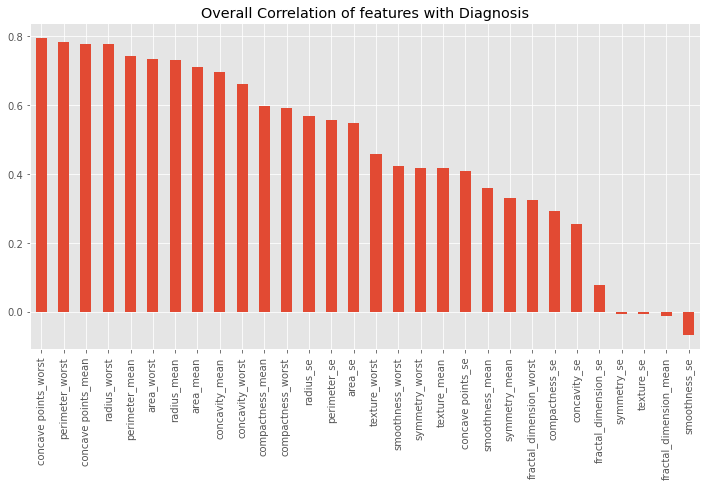

In [ ]:
data.corr()["target"].sort_values(ascending=False).drop("target").plot(kind='bar',figsize=(12,6))
plt.title("Overall Correlation of features with Diagnosis")

In [ ]:
data.isnull().sum().sum()

0

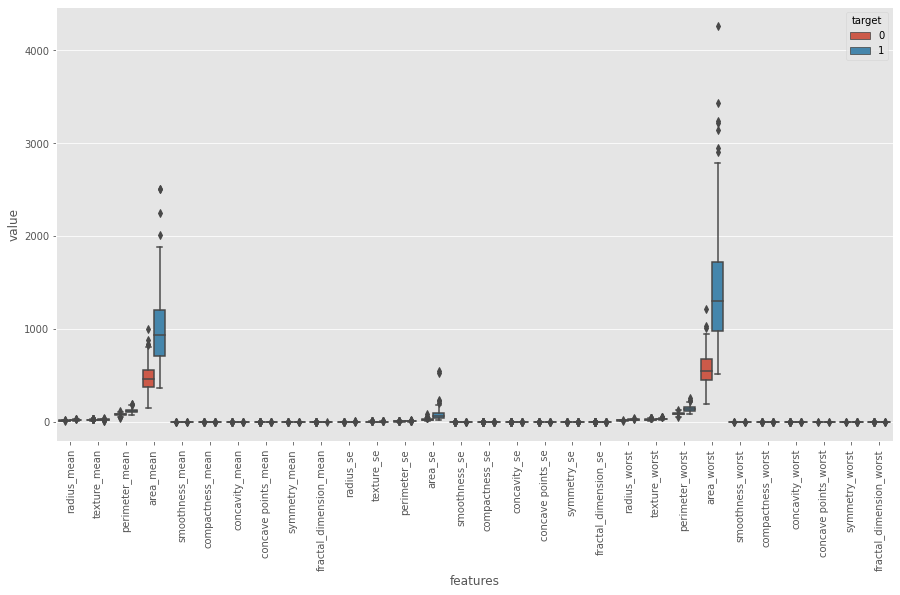

In [ ]:
data_melted=pd.melt(data, id_vars="target", var_name="features", value_name="value")
plt.figure(figsize=(15,8))
sns.boxplot(x="features", y="value", hue="target", data=data_melted)
plt.xticks(rotation=90)
plt.show()

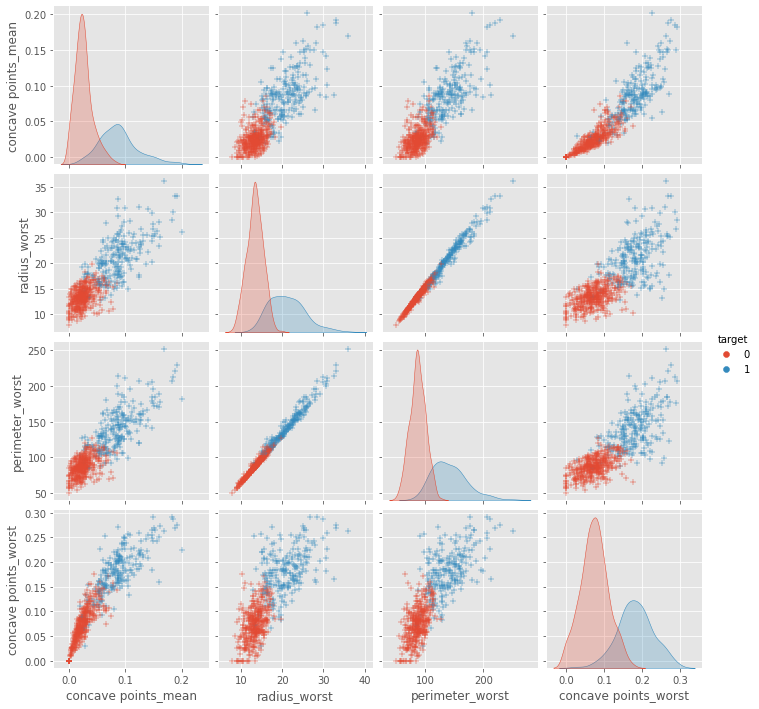

In [ ]:
sns.pairplot(data[corr_features], diag_kind="kde", markers="+", hue="target")
plt.show()

## C) Spliting into x and y components

In [ ]:
y=data.target
x=data.drop(["target"], axis=1)
columns=x.columns.tolist()
x.shape, y.shape

((569, 30), (569,))

In [ ]:
clf=LocalOutlierFactor()
y_pred=clf.fit_predict(x)
X_score=clf.negative_outlier_factor_
y_pred  # -1's are outliers. 1's are inliers.

array([ 1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1

In [ ]:
outlier_score=pd.DataFrame()
outlier_score["score"]=X_score
outlier_score.head(12)

,score
0,-1.422440
1,-1.066782
2,-0.978948
3,-1.596933
4,-1.069936
5,-1.773071
6,-1.015687
7,-1.251746
8,-1.380515
9,-1.644357


In [ ]:
threshold_outliers=-2.5
filtre=outlier_score["score"]< threshold_outliers
outlier_index=outlier_score[filtre].index.tolist()

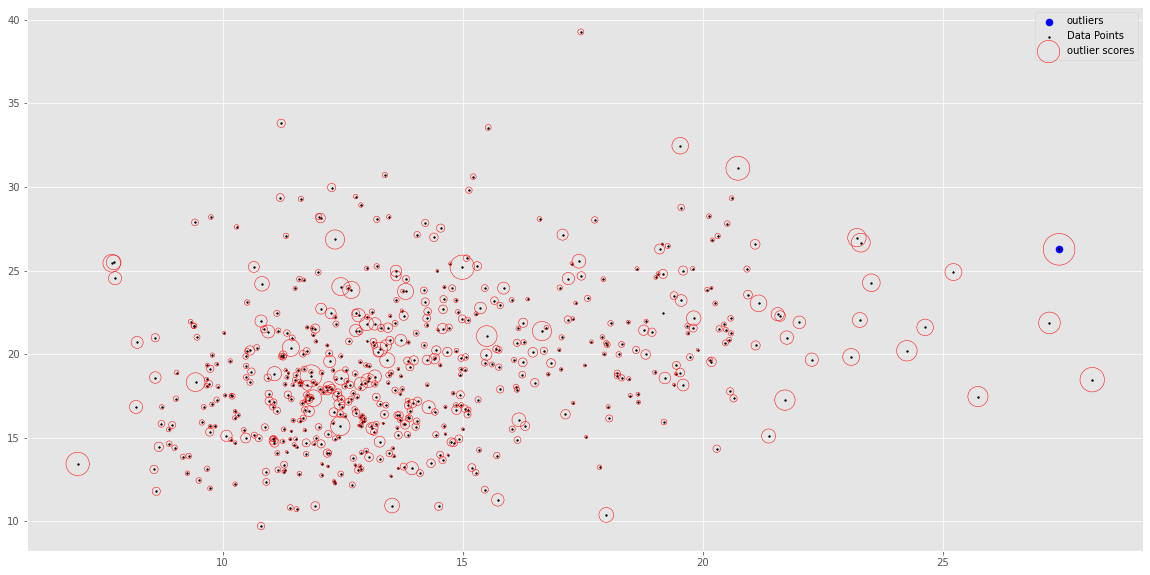

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x.iloc[outlier_index,0], x.iloc[outlier_index,1], color="blue",s=50 ,label="outliers")
plt.scatter(x.iloc[:,0], x.iloc[:,1], color="k", s=3 , label="Data Points")
radius=(X_score.max()-X_score)/(X_score.max()-X_score.min())
outlier_score["radius"]=radius
plt.scatter(x.iloc[:,0], x.iloc[:,1], s=1000*radius, edgecolors="r", facecolors="none", label="outlier scores")
plt.legend()
plt.show()

In [ ]:
x=x.drop(outlier_index)
y=y.drop(outlier_index).values
x.shape, y.shape  # previous was (569, 30)

((568, 30), (568,))

## D) Feature selection

In [ ]:
print(data.shape)
data.columns

(569, 31)


Index(['target', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

**Recursive feature elimination**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Build a logreg and compute the feature importances
model = LogisticRegression()

# create the RFE model and select 8 attributes
rfe = RFE(model, 20)
rfe = rfe.fit(x, y)

# summarize the selection of the attributes
list(x.columns[rfe.support_])

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'concavity_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'fractal_dimension_worst']

**Feature ranking with recursive feature elimination and cross-validation**

Optimal number of features: 12
Selected features: ['radius_mean', 'perimeter_mean', 'smoothness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'texture_se', 'radius_worst', 'concavity_worst', 'concave points_worst', 'fractal_dimension_worst']


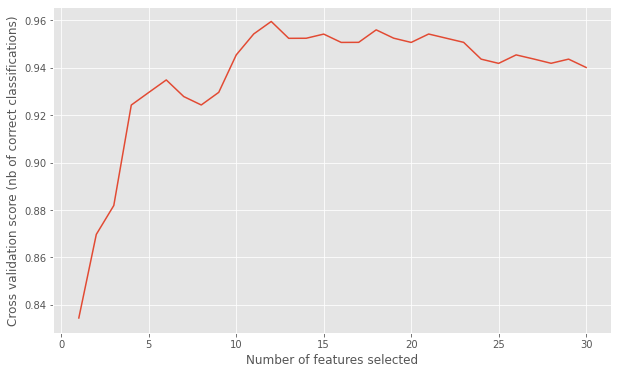

In [ ]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

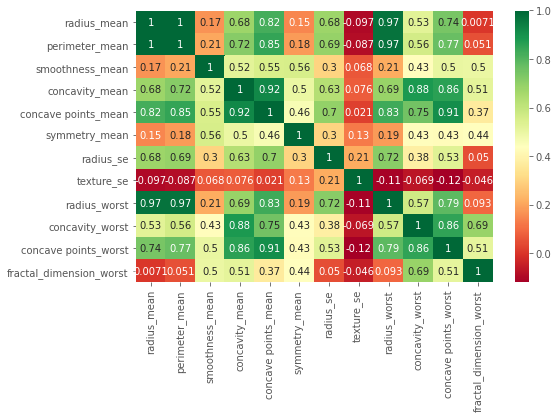

In [ ]:
selected_features = ['radius_mean', 'perimeter_mean', 'smoothness_mean', 'concavity_mean',
                    'concave points_mean', 'symmetry_mean', 'radius_se', 'texture_se', 'radius_worst',
                    'concavity_worst', 'concave points_worst', 'fractal_dimension_worst']
x1 = data[selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(x1.corr(), annot=True, cmap="RdYlGn")
plt.show()

## E) Model Training and evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=28, random_state = 555)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((540, 30), (28, 30), (540,), (28,))

In [ ]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(solver='liblinear', random_state=0)
model_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_test = model_log.predict(X_test)
y_pred_test

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1])

In [ ]:
# 0th index = (class 0 : B), 1st index = (class 1 : M)
var_df = model_log.predict_proba(X_test)
y_pred_prob_df = pd.DataFrame(var_df, columns=['class 0 : diagnosis (B)','class 1 : diagnosis (M)'])
y_pred_prob_df

,class 0 : diagnosis (B),class 1 : diagnosis (M)
0,9.976298e-01,0.002370
1,9.907451e-01,0.009255
2,9.995400e-01,0.000460
3,9.992105e-01,0.000790
4,9.445575e-01,0.055443
5,8.638275e-01,0.136173
6,9.974763e-01,0.002524
7,2.142785e-04,0.999786
8,9.945245e-01,0.005475
9,1.332268e-14,1.000000


In [ ]:
# probability of getting output as 0 - rain
model_log.predict_proba(X_test)[:,0]

array([9.97629784e-01, 9.90745147e-01, 9.99540000e-01, 9.99210487e-01,
       9.44557456e-01, 8.63827484e-01, 9.97476345e-01, 2.14278537e-04,
       9.94524502e-01, 1.33226763e-14, 9.98867091e-01, 9.67939128e-01,
       9.97851938e-01, 4.41757077e-02, 9.99260461e-01, 0.00000000e+00,
       7.50595509e-04, 9.96017253e-01, 3.67138537e-02, 9.89106129e-01,
       3.17413301e-01, 1.06566555e-01, 9.99929474e-01, 6.58113743e-03,
       9.57513990e-01, 9.95541228e-01, 9.99344577e-01, 1.54286940e-06])

In [ ]:
# probability of getting output as 1 - rain
model_log.predict_proba(X_test)[:,1]

array([2.37021613e-03, 9.25485331e-03, 4.59999641e-04, 7.89513202e-04,
       5.54425444e-02, 1.36172516e-01, 2.52365472e-03, 9.99785721e-01,
       5.47549849e-03, 1.00000000e+00, 1.13290876e-03, 3.20608718e-02,
       2.14806205e-03, 9.55824292e-01, 7.39539336e-04, 1.00000000e+00,
       9.99249404e-01, 3.98274746e-03, 9.63286146e-01, 1.08938706e-02,
       6.82586699e-01, 8.93433445e-01, 7.05264688e-05, 9.93418863e-01,
       4.24860100e-02, 4.45877201e-03, 6.55422624e-04, 9.99998457e-01])

In [ ]:
# check the overfitting
print('Training set score: {:.4f}'.format(model_log.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(model_log.score(X_test, y_test)))

Training set score: 0.9593
Test set score: 0.9643


In [ ]:
# fit the Logsitic Regression model with C=100
logreg100 = LogisticRegression(C=100, solver='liblinear', random_state=0)
logreg100.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(logreg100.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg100.score(X_test, y_test)))

Training set score: 0.9722
Test set score: 0.9643


In [ ]:
bb = pd.DataFrame(y_test)
bb.value_counts()

0    19
1     9
dtype: int64

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[18  1]
 [ 0  9]]

True Positives(TP) =  18

True Negatives(TN) =  9

False Positives(FP) =  1

False Negatives(FN) =  0


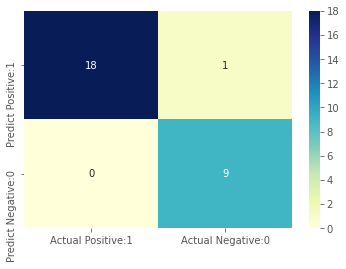

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## F) Classification metrices

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.90      1.00      0.95         9

    accuracy                           0.96        28
   macro avg       0.95      0.97      0.96        28
weighted avg       0.97      0.96      0.96        28



In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

# print classification accuracy
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))


# print precision score
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))

# print recall score
recall = TP / float(TP + FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

# print true positive rate
true_positive_rate = TP / float(TP + FN)
print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

# print false positive rate
false_positive_rate = FP / float(FP + TN)
print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

# print specificity
specificity = TN / (TN + FP)
print('Specificity : {0:0.4f}'.format(specificity))

Classification accuracy : 0.9643
Classification error : 0.0357
Precision : 0.9474
Recall or Sensitivity : 1.0000
True Positive Rate : 1.0000
False Positive Rate : 0.1000
Specificity : 0.9000


Train/Test split results:
LogisticRegression accuracy is 0.964
LogisticRegression log_loss is 0.073
LogisticRegression auc is 1.000


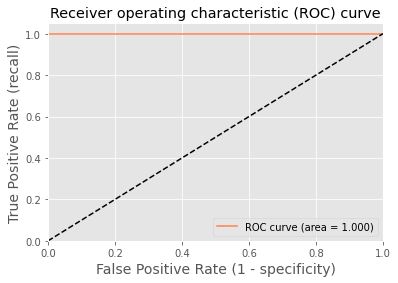

Using a threshold of 0.770 guarantees a sensitivity of 1.000 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [ ]:
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

## G) Adjusting the threshold level

In [ ]:
y_pred_prob = logreg100.predict_proba(X_test)[0:10]
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['class 0 : diagnosis (B)','class 1 : diagnosis (M)'])
y_pred_prob_df.head()

,class 0 : diagnosis (B),class 1 : diagnosis (M)
0,0.999330,0.000670
1,0.998635,0.001365
2,0.999961,0.000039
3,0.999920,0.000080
4,0.976546,0.023454


In [ ]:
# print the first 10 predicted probabilities for class 1 - Probability of M
logreg100.predict_proba(X_test)[0:10, 1]

# store the predicted probabilities for class 1 - Probability of rain
y_pred1 = logreg100.predict_proba(X_test)[:, 1]
y_pred1

array([6.69940487e-04, 1.36462298e-03, 3.87049806e-05, 8.01547209e-05,
       2.34538316e-02, 1.15255927e-01, 8.99625703e-05, 9.99992964e-01,
       1.04058912e-03, 1.00000000e+00, 1.36878746e-04, 1.70502977e-02,
       3.21899171e-04, 9.79038039e-01, 6.69938037e-05, 1.00000000e+00,
       9.99905101e-01, 1.97694160e-04, 9.98612795e-01, 1.63331677e-03,
       7.30131544e-01, 9.73976698e-01, 2.99352232e-07, 9.92529976e-01,
       5.83011068e-03, 5.84605932e-04, 1.74300650e-05, 9.99999977e-01])

Text(0, 0.5, 'Frequency')

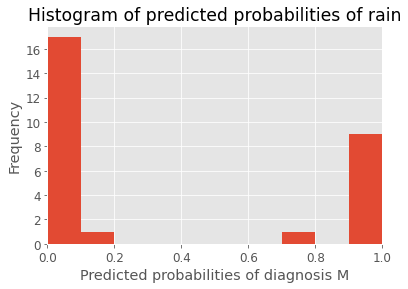

In [ ]:
plt.rcParams['font.size'] = 12
plt.hist(y_pred1, bins = 10)
plt.title('Histogram of predicted probabilities of rain')
plt.xlim(0,1)
plt.xlabel('Predicted probabilities of diagnosis M')
plt.ylabel('Frequency')

**Lower the threshold**

- We can see that the above histogram is positive skewed.
- The first column tell us that there are approximately 17 observations with probability between 0.0 and 0.1.
- There are small number of observations with probability > 0.5.
- So, these small number of observations predict that there diagnosis with B.
- Majority of observations predict that there will be diagnosis with M.

In [ ]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(X_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')

With 0.1 threshold the Confusion Matrix is  
 [[16  3]
 [ 0  9]] 
 with 25 correct predictions and 0 Type II errors( False Negatives) 

 Sensitivity:  1.0 Specificity:  0.8421052631578947 



With 0.2 threshold the Confusion Matrix is  
 [[18  1]
 [ 0  9]] 
 with 27 correct predictions and 0 Type II errors( False Negatives) 

 Sensitivity:  1.0 Specificity:  0.9473684210526315 



With 0.3 threshold the Confusion Matrix is  
 [[18  1]
 [ 0  9]] 
 with 27 correct predictions and 0 Type II errors( False Negatives) 

 Sensitivity:  1.0 Specificity:  0.9473684210526315 



With 0.4 threshold the Confusion Matrix is  
 [[18  1]
 [ 0  9]] 
 with 27 correct predictions and 0 Type II errors( False Negatives) 

 Sensitivity:  1.0 Specificity:  0.9473684210526315 



